In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import entropy
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import os

sys.path.append(os.path.abspath(".."))


SEED = 1

data=np.load("../datasets/labeled/first_batch_multi_labels.npz")
data2=np.load("../datasets/labeled/second_batch_multi_labels.npz")
data3=np.load("../datasets/labeled/third_batch_multi_labels.npz")

X1=data["X"]
y1=data["y"]

X2=data2["X"]
y2=data2["y"]

X3=data3["X"]
y3=data3["y"]

X=np.concatenate((X1,X2,X3),axis=0)
y=np.concatenate((y1,y2,y3),axis=0)

XX=pd.DataFrame(X)
yy=pd.DataFrame(y)
XX.rename(columns={0:"user",1:"item",2:"rating"},inplace=True)
yy.rename(columns={0:"user",1:"label"},inplace=True)

In [2]:
# Merge labels into main dataset
XX = XX.merge(yy, on="user", how="left").sort_values(by=["user", "item"]).reset_index(drop=True)

print(XX.shape)
XX.head()

(524883, 4)


,user,item,rating,label
0,0,9,0,0
1,0,12,10,0
2,0,13,10,0
3,0,15,10,0
4,0,16,1,0


In [3]:
from utils.feature_transformation import aggregate_features

user_features = aggregate_features(XX)
user_features = user_features.merge(yy, on="user", how="left")
print(user_features.shape)
# user_features.to_csv("user_features.csv", index=False)
user_features.head()


(3300, 90)


,user,review_count,avg_rating,std_rating,like_count,dislike_count,unknown_count,neutral_count,like_pct,dislike_pct,...,popularity_skew,rating_polarity,activity_weighted_skew,switch_pct,dominant_rating,dominance_ratio,highly_rated_movie_count,highly_rated_movie_pct,contrarian_lowly_rated_like_pct,label
0,0,168,5.946429,5.253181,100,5,49,14,0.595238,0.029762,...,2282,0.565476,-2.817185,0.714286,10,0.595238,23,0.136905,0.017857,0
1,1,208,3.158654,5.890205,76,16,57,59,0.365385,0.076923,...,2333,0.288462,-1.703270,0.740385,10,0.365385,23,0.110577,0.000000,0
2,2,195,1.025641,7.750913,66,52,60,17,0.338462,0.266667,...,2294,0.071795,-1.356825,0.805128,10,0.338462,24,0.123077,0.015385,3
3,3,41,1.073171,6.455193,10,7,14,10,0.243902,0.170732,...,1990,0.073171,-0.522866,0.634146,1,0.341463,10,0.243902,0.000000,0
4,4,6,6.833333,4.915960,4,0,1,1,0.666667,0.000000,...,1578,0.666667,-1.449192,0.833333,10,0.666667,0,0.000000,0.000000,0


In [4]:
from tqdm import tqdm
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

df = user_features.copy()
print(df.shape)
df.head()

(3300, 90)


,user,review_count,avg_rating,std_rating,like_count,dislike_count,unknown_count,neutral_count,like_pct,dislike_pct,...,popularity_skew,rating_polarity,activity_weighted_skew,switch_pct,dominant_rating,dominance_ratio,highly_rated_movie_count,highly_rated_movie_pct,contrarian_lowly_rated_like_pct,label
0,0,168,5.946429,5.253181,100,5,49,14,0.595238,0.029762,...,2282,0.565476,-2.817185,0.714286,10,0.595238,23,0.136905,0.017857,0
1,1,208,3.158654,5.890205,76,16,57,59,0.365385,0.076923,...,2333,0.288462,-1.703270,0.740385,10,0.365385,23,0.110577,0.000000,0
2,2,195,1.025641,7.750913,66,52,60,17,0.338462,0.266667,...,2294,0.071795,-1.356825,0.805128,10,0.338462,24,0.123077,0.015385,3
3,3,41,1.073171,6.455193,10,7,14,10,0.243902,0.170732,...,1990,0.073171,-0.522866,0.634146,1,0.341463,10,0.243902,0.000000,0
4,4,6,6.833333,4.915960,4,0,1,1,0.666667,0.000000,...,1578,0.666667,-1.449192,0.833333,10,0.666667,0,0.000000,0.000000,0


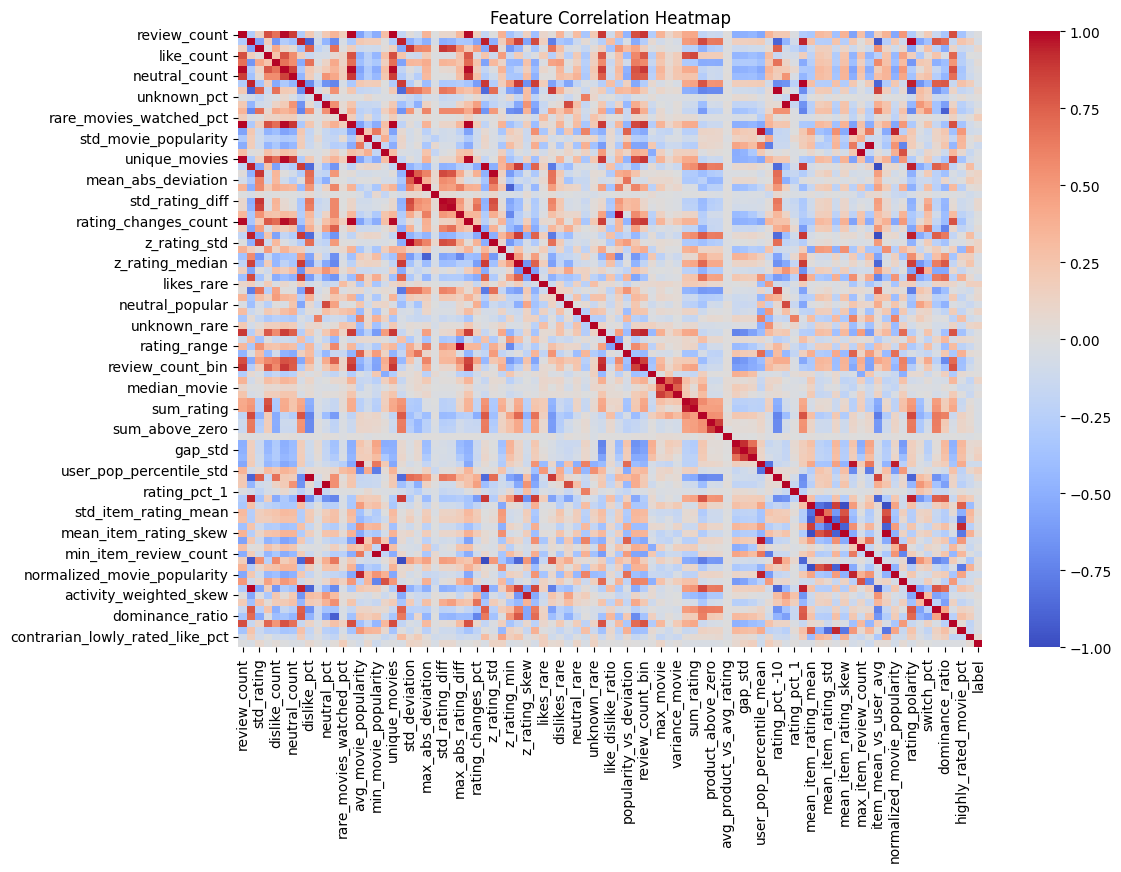

In [5]:
df.drop(columns=["user"], inplace=True)
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [6]:
correlated_features = set()
threshold = 0.9

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

df.drop(columns=correlated_features, inplace=True, errors="ignore")
print(f"Dropped correlated features: {correlated_features}")

Dropped correlated features: {'rating_pct_-10', 'rating_pct_1', 'change_direction_count', 'item_skew_bias', 'z_rating_min', 'dominance_ratio', 'item_mean_vs_user_avg', 'mean_abs_rating_diff', 'z_rating_mean', 'mean_item_rating_skew', 'unknown_count', 'rating_polarity', 'min_item_review_count', 'mean_deviation', 'mean_item_rating_std', 'entropy_by_count', 'rating_changes_count', 'review_count_bin', 'sum_rating', 'user_pop_percentile_mean', 'highly_rated_movie_pct', 'z_rating_std', 'max_item_review_count', 'mean_item_review_count', 'activity_weighted_skew', 'unique_movies', 'rating_pct_10', 'normalized_movie_popularity', 'like_pct', 'rating_pct_0', 'gap_std', 'rating_range'}


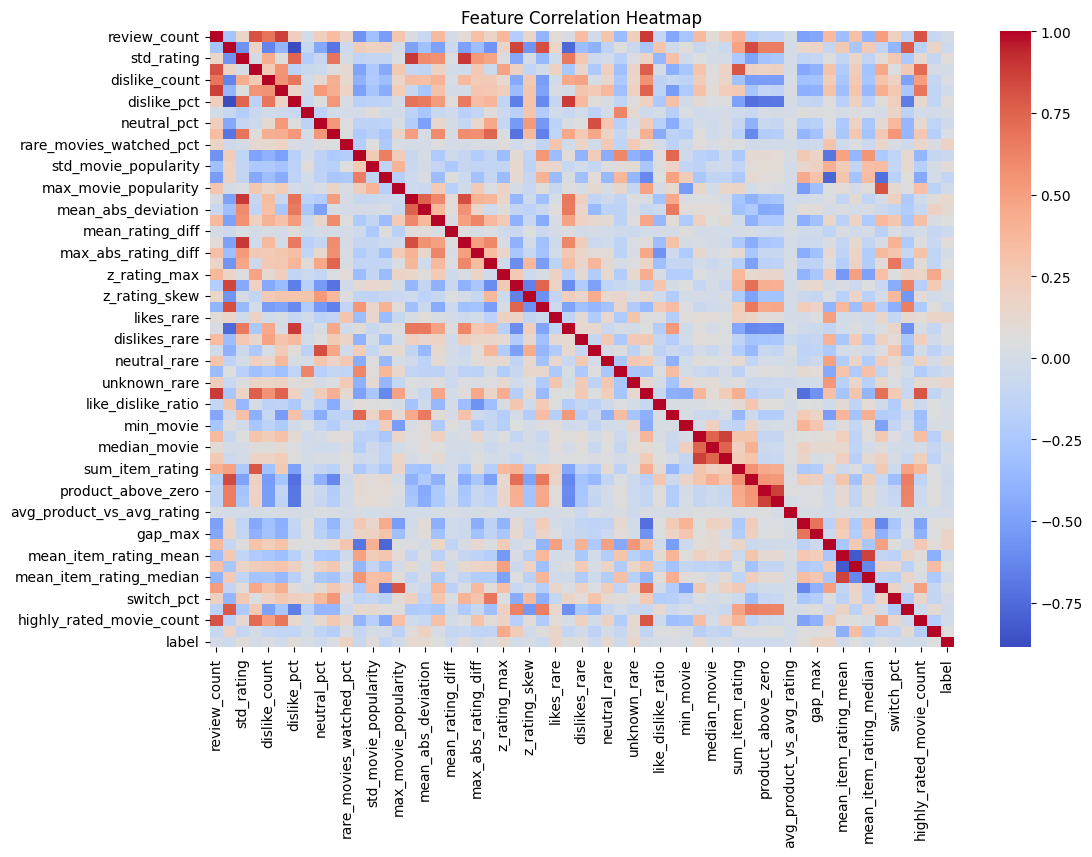

In [7]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [8]:
# Define features and target
X = df.drop(columns=["label"])
y = df["label"]

print(X.columns)
X.head()

Index(['review_count', 'avg_rating', 'std_rating', 'like_count',
       'dislike_count', 'neutral_count', 'dislike_pct', 'unknown_pct',
       'neutral_pct', 'rating_entropy', 'rare_movies_watched_pct',
       'avg_movie_popularity', 'std_movie_popularity', 'min_movie_popularity',
       'max_movie_popularity', 'std_deviation', 'mean_abs_deviation',
       'max_abs_deviation', 'mean_rating_diff', 'std_rating_diff',
       'max_abs_rating_diff', 'rating_changes_pct', 'z_rating_max',
       'z_rating_median', 'z_rating_skew', 'likes_popular', 'likes_rare',
       'dislikes_popular', 'dislikes_rare', 'neutral_popular', 'neutral_rare',
       'unknown_popular', 'unknown_rare', 'interaction_entropy',
       'like_dislike_ratio', 'popularity_vs_deviation', 'min_movie',
       'max_movie', 'median_movie', 'variance_movie', 'sum_item_rating',
       'average_product', 'product_above_zero', 'sum_above_zero',
       'avg_product_vs_avg_rating', 'gap_mean', 'gap_max',
       'user_pop_percentile_

,review_count,avg_rating,std_rating,like_count,dislike_count,neutral_count,dislike_pct,unknown_pct,neutral_pct,rating_entropy,...,gap_max,user_pop_percentile_std,mean_item_rating_mean,std_item_rating_mean,mean_item_rating_median,popularity_skew,switch_pct,dominant_rating,highly_rated_movie_count,contrarian_lowly_rated_like_pct
0,168,5.946429,5.253181,100,5,14,0.029762,0.291667,0.083333,0.979856,...,25.0,0.202953,2.880404,2.164212,2.684524,2282,0.714286,10,23,0.017857
1,208,3.158654,5.890205,76,16,59,0.076923,0.274038,0.283654,1.277318,...,21.0,0.213025,3.075789,1.816218,2.415865,2333,0.740385,10,23,0.000000
2,195,1.025641,7.750913,66,52,17,0.266667,0.307692,0.087179,1.294501,...,28.0,0.178840,2.979712,1.911067,2.600000,2294,0.805128,10,24,0.015385
3,41,1.073171,6.455193,10,7,10,0.170732,0.341463,0.243902,1.356990,...,38.0,0.179592,3.641043,1.858079,3.963415,1990,0.634146,1,10,0.000000
4,6,6.833333,4.915960,4,0,1,0.000000,0.166667,0.166667,0.867563,...,192.0,0.206937,3.094075,1.703597,0.833333,1578,0.833333,10,0,0.000000


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   review_count                     3300 non-null   int64  
 1   avg_rating                       3300 non-null   float64
 2   std_rating                       3300 non-null   float64
 3   like_count                       3300 non-null   int64  
 4   dislike_count                    3300 non-null   int64  
 5   neutral_count                    3300 non-null   int64  
 6   dislike_pct                      3300 non-null   float64
 7   unknown_pct                      3300 non-null   float64
 8   neutral_pct                      3300 non-null   float64
 9   rating_entropy                   3300 non-null   float64
 10  rare_movies_watched_pct          3300 non-null   float64
 11  avg_movie_popularity             3300 non-null   float64
 12  std_movie_popularity

In [10]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

print("🔹 Original Class Distribution:", Counter(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=SEED)

smote = SMOTE(sampling_strategy='not majority', random_state=SEED)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("🔹 Distribution after SMOTE (only minority oversampled):", Counter(y_train_over))

tomek = TomekLinks(sampling_strategy='not majority')
X_train_resampled, y_train_resampled = tomek.fit_resample(X_train_over, y_train_over)
print("🔹 Final Resampled Distribution (After applying Tomek on minority):", Counter(y_train_resampled))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

🔹 Original Class Distribution: Counter({0: 3000, 3: 60, 4: 60, 2: 60, 5: 60, 1: 60})
🔹 Distribution after SMOTE (only minority oversampled): Counter({0: 2700, 4: 2700, 3: 2700, 1: 2700, 2: 2700, 5: 2700})
🔹 Final Resampled Distribution (After applying Tomek on minority): Counter({0: 2700, 3: 2666, 5: 2514, 2: 2502, 4: 2468, 1: 2458})


In [11]:
import optuna
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import json

params_file = "best_xgb_params.json"

if os.path.exists(params_file):
    print("Hyperparameters found.")
    with open(params_file, "r") as f:
        best_params = json.load(f)
else:
    def objective(trial):
        params = {
            "objective": "multi:softprob",
            "num_class": len(np.unique(y_train_resampled)),
            "eval_metric": "mlogloss",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 9),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 0.2),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
            "random_state": SEED,
            "tree_method": "hist",
            "predictor": "cpu_predictor",
            "verbosity": 0,
            "n_jobs": 1
        }

        model = xgb.XGBClassifier(**params)
        model.fit(X_train_scaled, y_train_resampled)
        y_pred_proba = model.predict_proba(X_test_scaled)

        auc_scores = []
        for i in range(y_pred_proba.shape[1]):
            binary_true = (y_test == i).astype(int)
            try:
                auc = roc_auc_score(binary_true, y_pred_proba[:, i])
                auc_scores.append(auc)
            except:
                auc_scores.append(0)

        return np.mean(auc_scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=80)

    best_params = study.best_params

    with open(params_file, "w") as f:
        json.dump(best_params, f)

    print(best_params)


Hyperparameters found.


In [12]:
# num_classes = len(np.unique(y))
# xgb_model = xgb.XGBClassifier(
#     **best_params,
#     objective='multi:softprob',
#     num_class=num_classes,
#     eval_metric='mlogloss',
#     random_state=SEED,
#     reg_lambda=0.1,
#     n_jobs=1,
# )

# xgb_model.fit(X_train_scaled, y_train_resampled)

# y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)

# print("XGBoost AUC Scores per Class:")
# auc_per_class_xgb = {}
# for i in range(y_pred_proba_xgb.shape[1]):
#     binary_true = (y_test == i).astype(int)
#     try:
#         auc = roc_auc_score(binary_true, y_pred_proba_xgb[:, i])
#         auc_per_class_xgb[i] = auc
#         print(f"  Class {i}: AUC = {auc:.3f}")
#     except Exception as e:
#         auc_per_class_xgb[i] = None
#         print(f"  Class {i}: AUC could not be computed")

# k = 5
# AUC_0 = auc_per_class_xgb[0]
# anomaly_aucs = [auc_per_class_xgb[i] for i in range(1, k+1) if i in auc_per_class_xgb]

# final_metric = (0.5 * AUC_0) + (0.5 / k) * sum(anomaly_aucs)

# print(f"\nFinal Evaluation Metric: {final_metric:.3f}")

In [13]:
from collections import Counter
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import xgboost as xgb

model_features = list(X_train.columns)

# Combine train and test
X_full = np.concatenate((X_train, X_test), axis=0)
y_full = np.concatenate((y_train, y_test), axis=0)
print("🔹 Original Class Distribution (Full Dataset):", Counter(y_full))

# Setting sampling_strategy='not majority' means only classes other than the majority are oversampled.
smote = SMOTE(sampling_strategy='not majority', random_state=SEED)
X_over, y_over = smote.fit_resample(X_full, y_full)
print("🔹 Distribution after SMOTE (only minority oversampled):", Counter(y_over))

tomek = TomekLinks(sampling_strategy='not majority')
X_resampled, y_resampled = tomek.fit_resample(X_over, y_over)
print("🔹 Final Resampled Distribution (After applying Tomek on minority):", Counter(y_resampled))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(pd.DataFrame(X_resampled, columns=model_features))

num_classes = len(np.unique(y_full))
xgb_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    num_class=num_classes,
    eval_metric='mlogloss',
    random_state=SEED,
    reg_lambda=0.1,
    n_jobs=1,
)

xgb_model.fit(X_scaled, y_resampled)

🔹 Original Class Distribution (Full Dataset): Counter({0: 3000, 4: 60, 3: 60, 1: 60, 2: 60, 5: 60})
🔹 Distribution after SMOTE (only minority oversampled): Counter({0: 3000, 4: 3000, 3: 3000, 1: 3000, 2: 3000, 5: 3000})
🔹 Final Resampled Distribution (After applying Tomek on minority): Counter({0: 3000, 3: 2953, 5: 2787, 2: 2752, 4: 2713, 1: 2711})


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5565512173747804, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=0.18141790000818964, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.036655734544611865,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=924, n_jobs=1, num_class=6, ...)

In [14]:
import joblib

# Save objects
joblib.dump(model_features, "../testing/model_features.pkl")
joblib.dump(scaler, "../testing/scaler.pkl")
joblib.dump(xgb_model, "../testing/xgb_model.pkl")

['../testing/xgb_model.pkl']

# Feature Analysis

 98%|===================| 591/600 [01:04<00:00]        


📊 SHAP Summary for Class 0


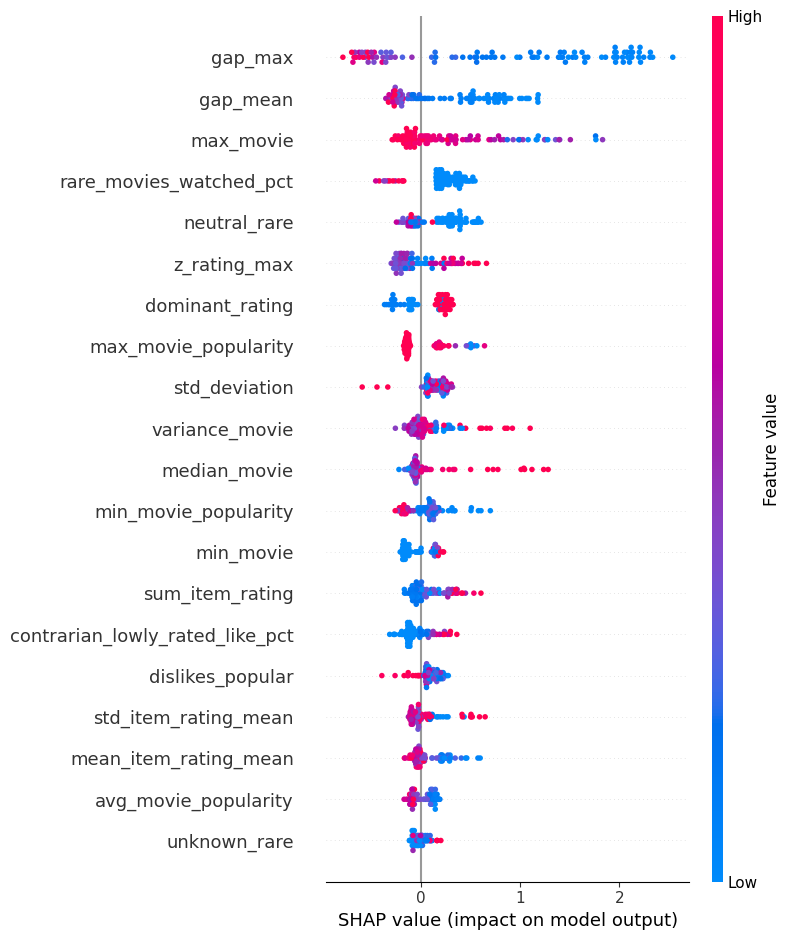


📊 SHAP Summary for Class 1


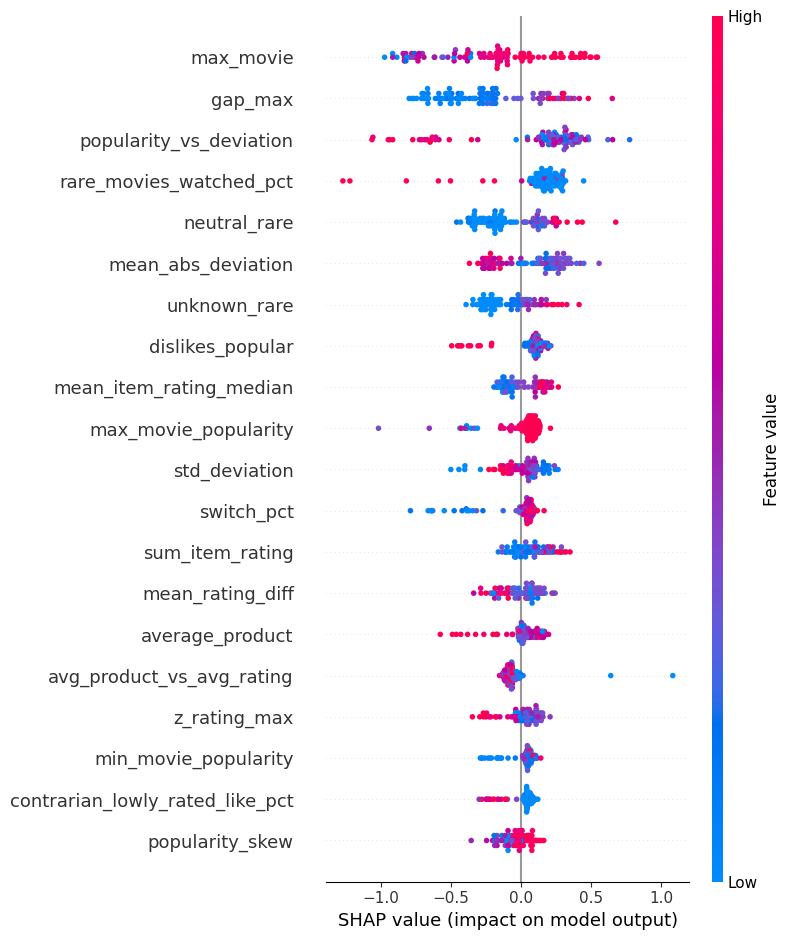


📊 SHAP Summary for Class 2


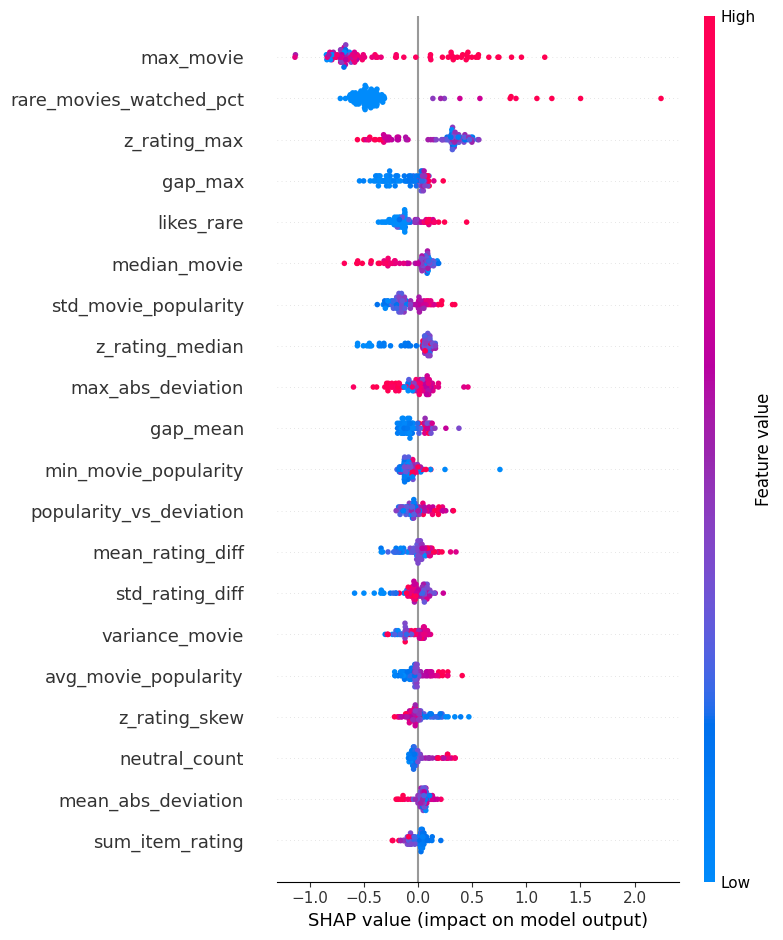


📊 SHAP Summary for Class 3


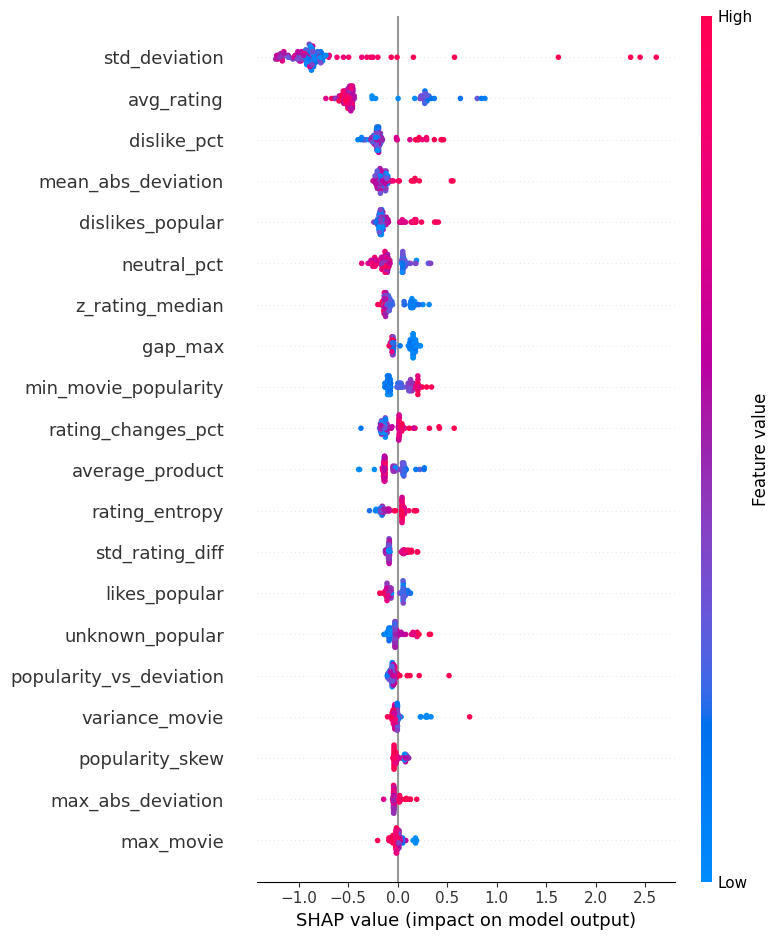


📊 SHAP Summary for Class 4


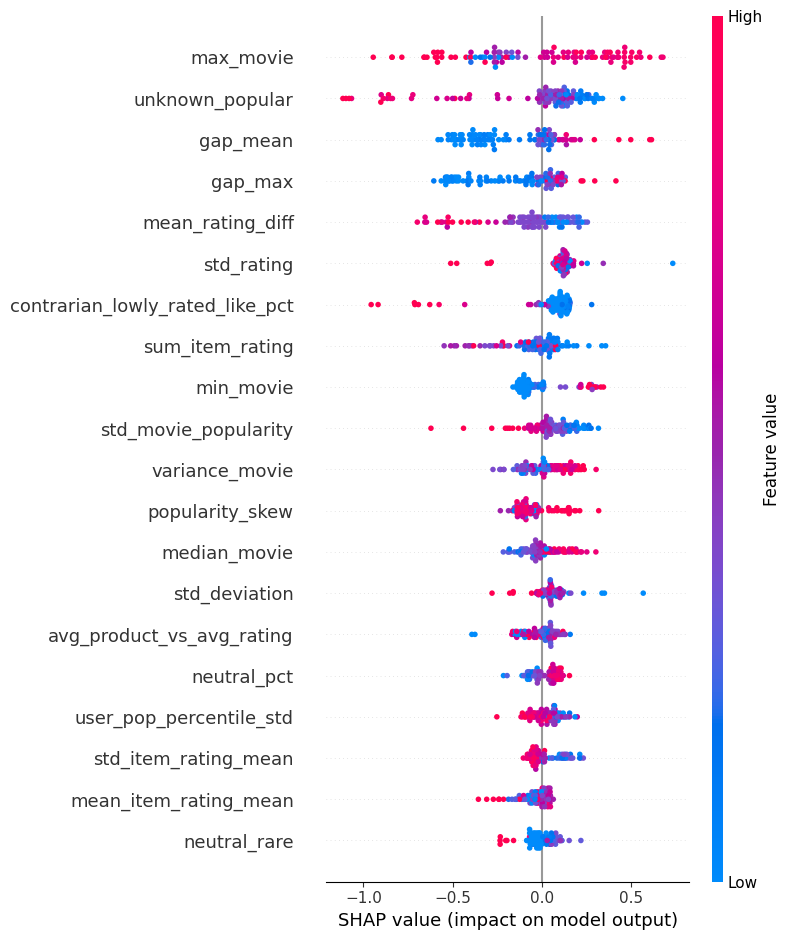


📊 SHAP Summary for Class 5


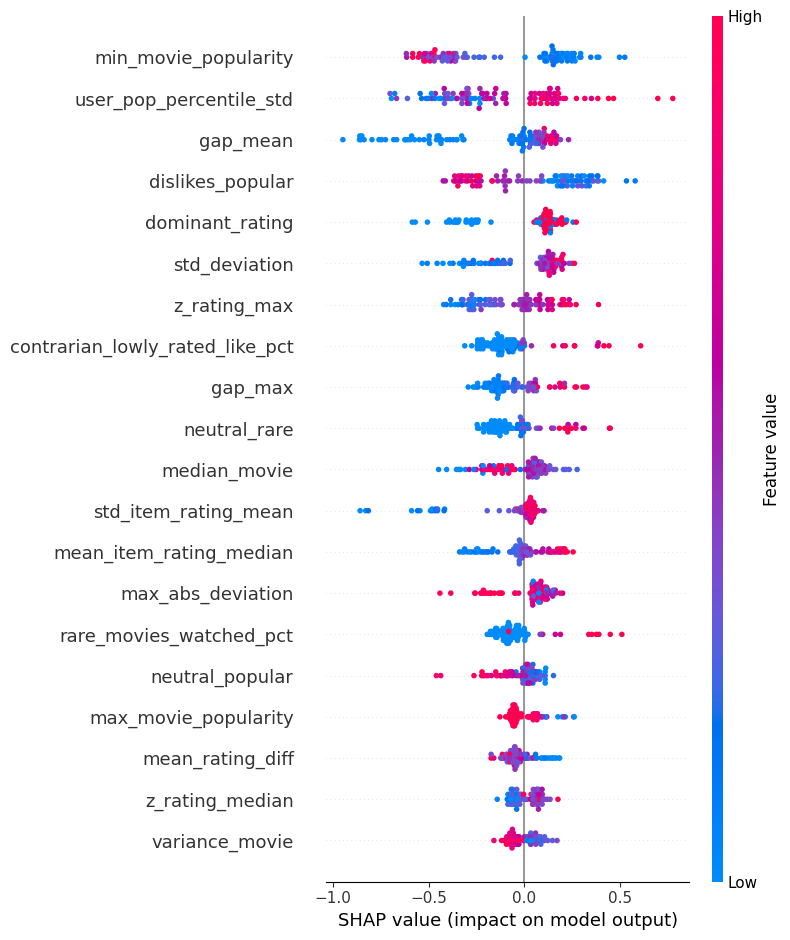

In [15]:
import shap

explainer = shap.TreeExplainer(xgb_model, X_train_scaled)
shap_values = explainer(X_test_scaled[:100], check_additivity=False)

shap_array = shap_values.values  # shape: (n_samples, n_features, n_classes)

# Loop over classes and show SHAP summary
for class_id in range(num_classes):
    print(f"\n📊 SHAP Summary for Class {class_id}")
    shap.summary_plot(
        shap_array[:, :, class_id],  # SHAP values for this class
        X_test_scaled[:100],
        feature_names=model_features,
        show=True
    )



🧠 SHAP Decision Plot for Class 0


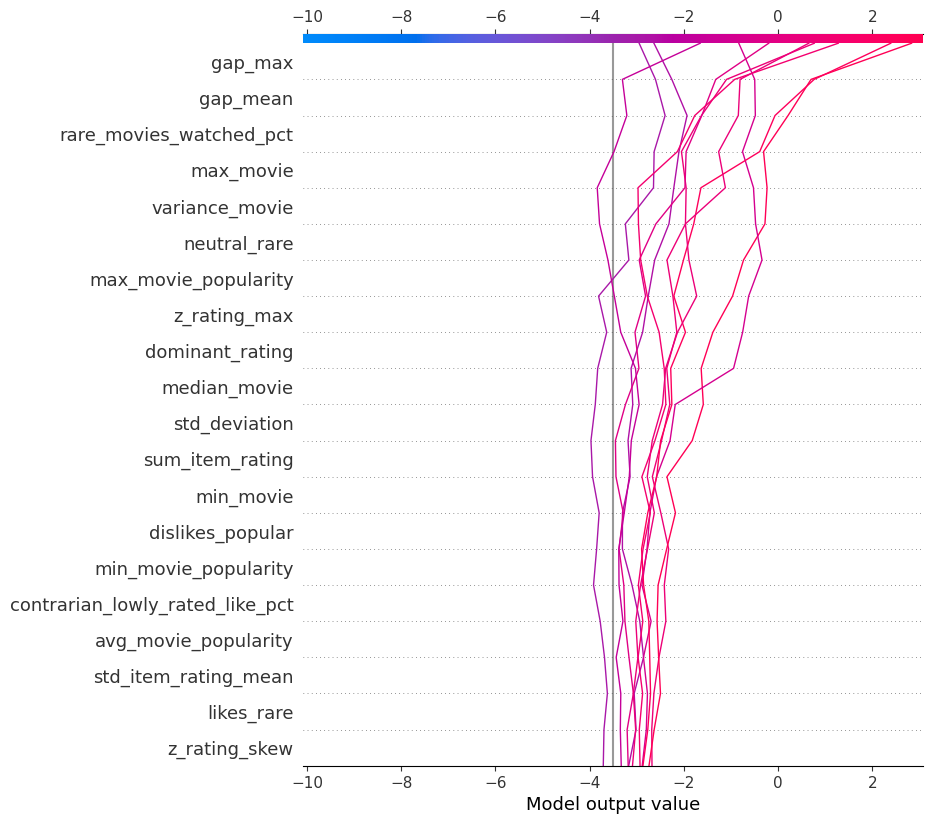


🧠 SHAP Decision Plot for Class 1


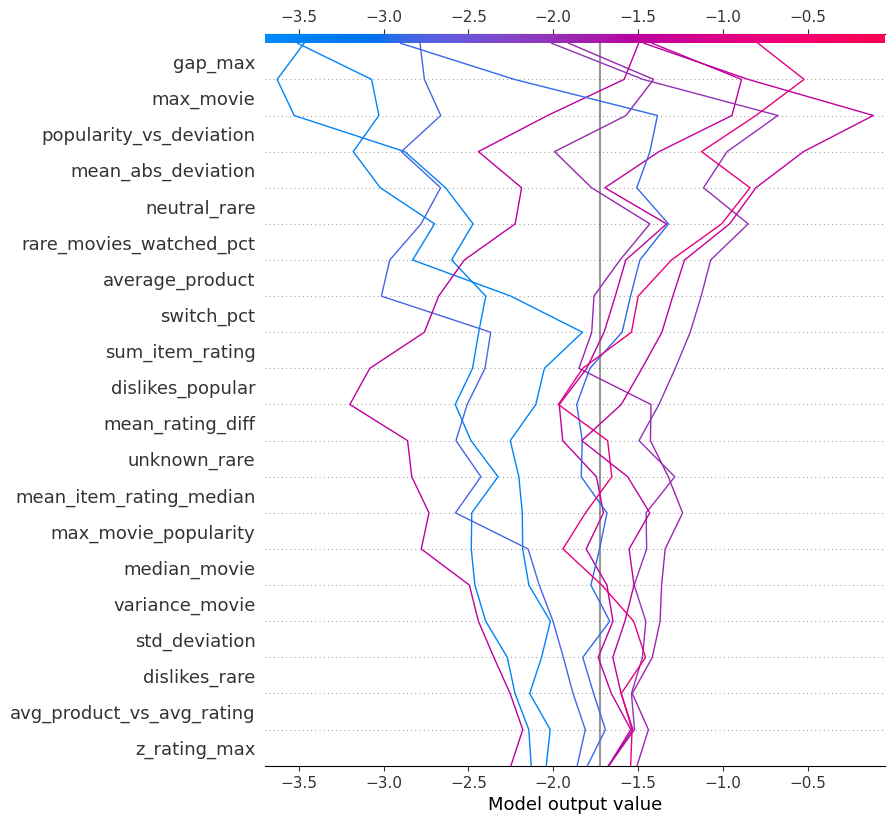


🧠 SHAP Decision Plot for Class 2


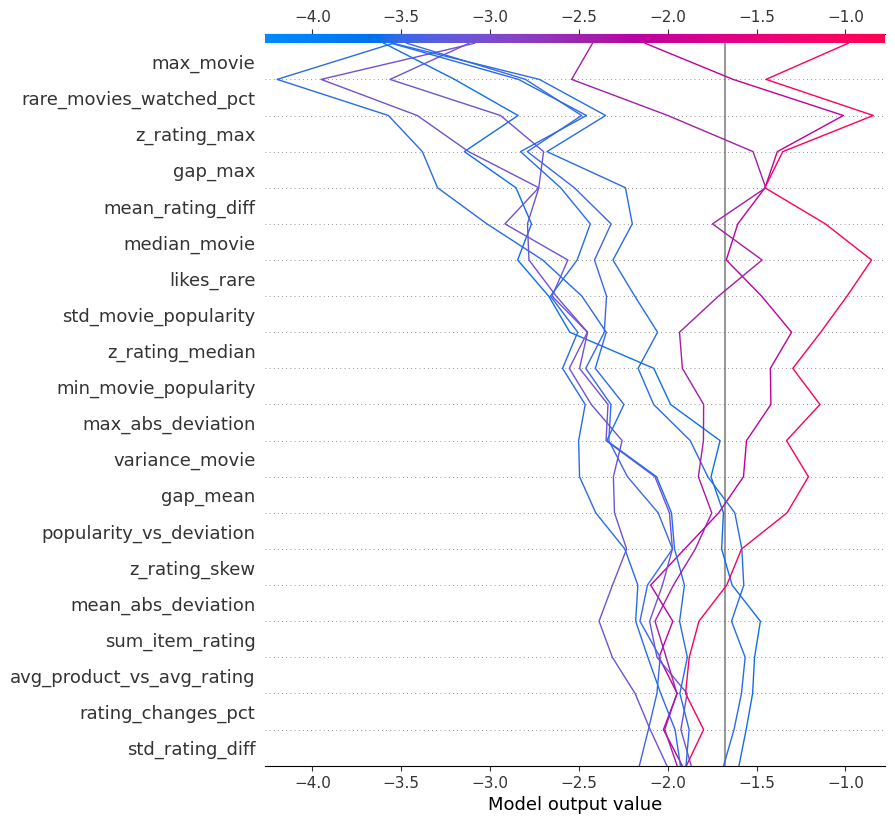


🧠 SHAP Decision Plot for Class 3


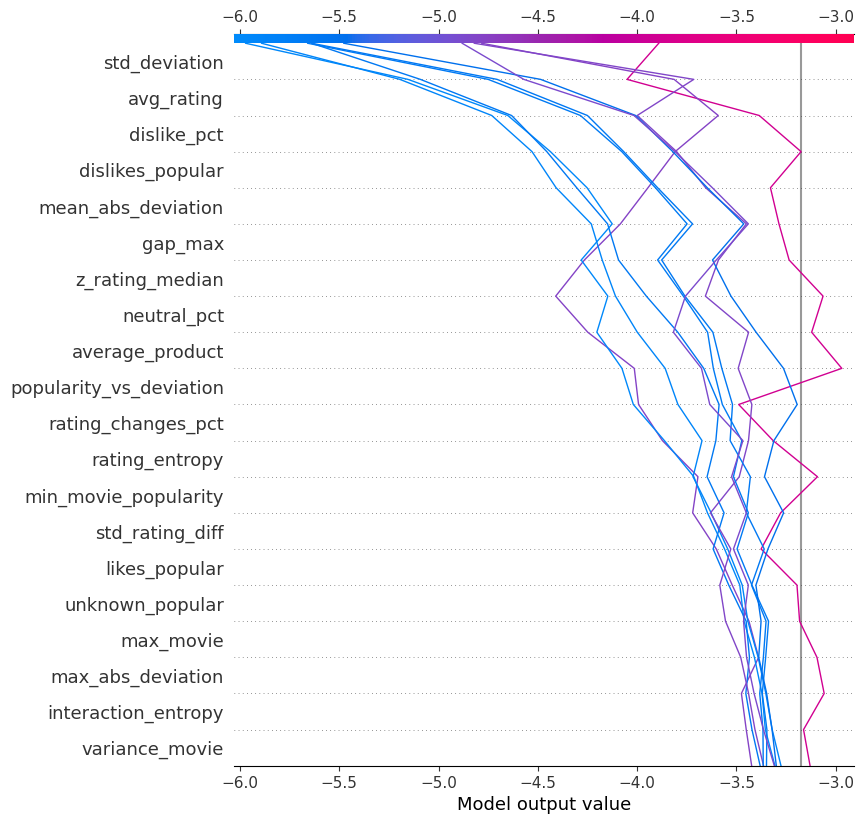


🧠 SHAP Decision Plot for Class 4


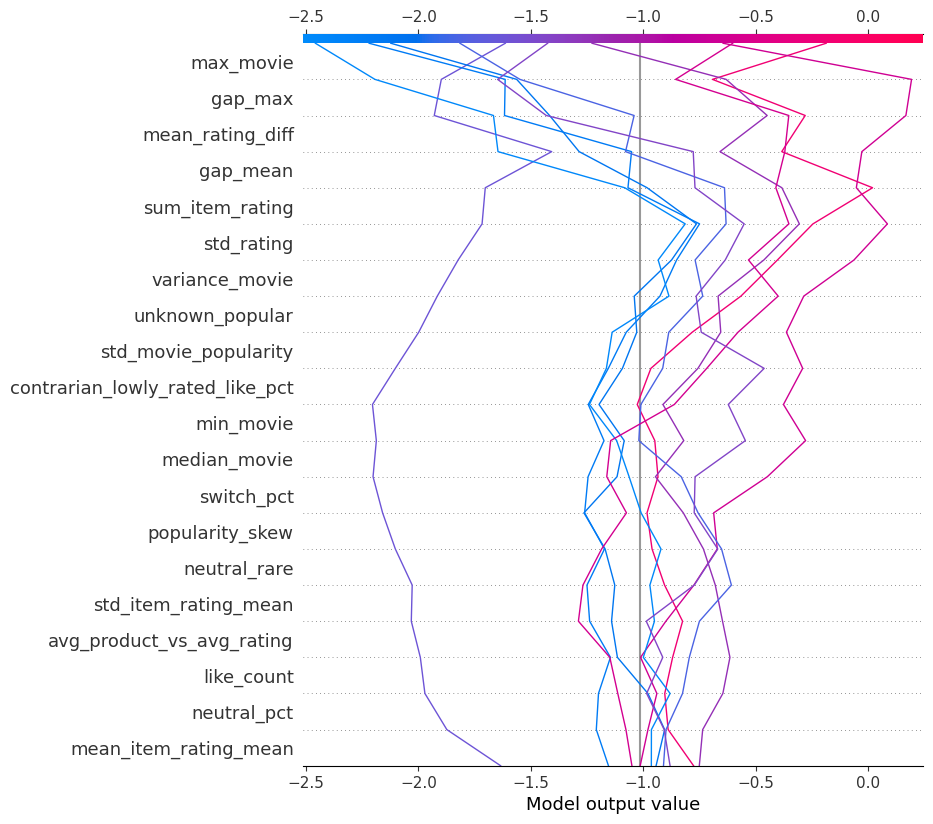


🧠 SHAP Decision Plot for Class 5


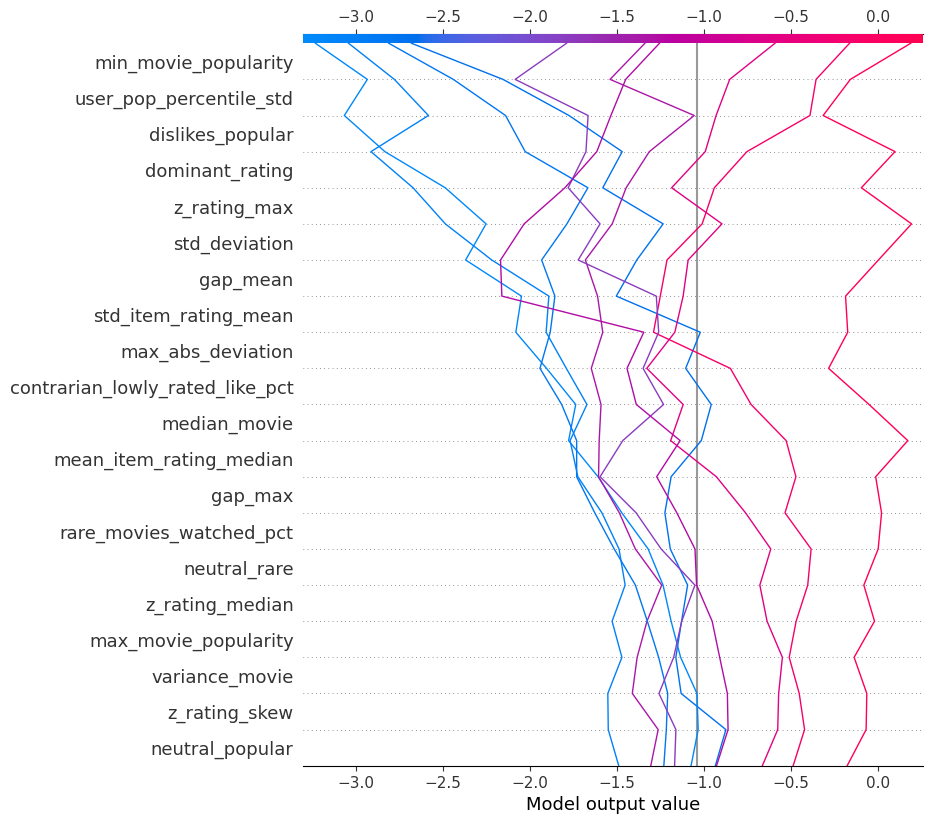

In [16]:
if isinstance(X_test_scaled, np.ndarray):
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=model_features)

for class_id in range(num_classes):
    print(f"\n🧠 SHAP Decision Plot for Class {class_id}")
    
    shap.decision_plot(
        explainer.expected_value[class_id],
        shap_array[:10, :, class_id],
        X_test_scaled.iloc[:10],
        feature_names=model_features,
        show=True
    )